In [14]:
pip install xlsxwriter

     |████████████████████████████████| 144 kB 2.9 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [14]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
import xlsxwriter

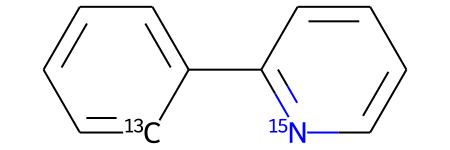

In [2]:
cn1 = Chem.MolFromSmiles('C1(C2=[15N]C=CC=C2)=CC=CC=[13C]1',sanitize=False)
cn1

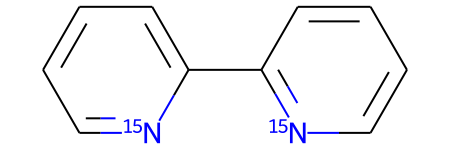

In [14]:
nn1 = Chem.MolFromSmiles('C1(C2=[15N]C=CC=C2)=CC=CC=[15N]1')
nn1

In [3]:
def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol

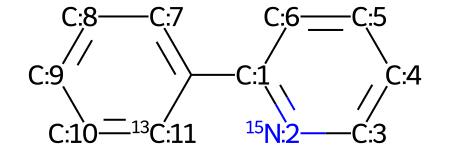

In [4]:
# With atom index
mol_with_atom_index(cn1)

In [20]:
symbols = [atom.GetSymbol() for atom in cn1.GetAtoms()]
print(symbols)

['C', 'C', 'N', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C']


In [6]:
def bridge_index(mol):
    alist = []
    for atom in mol.GetAtoms():
        if atom.GetIsotope()>0:
            alist.append(atom.GetIdx())
    return alist
print(bridge_index(cn1))

[2, 11]


In [9]:
Ir = Chem.MolFromSmiles('[Ir+3]')

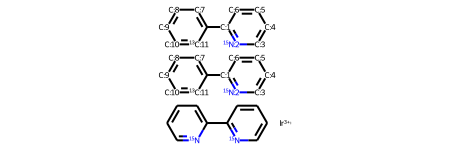

In [16]:
combo1 = Chem.CombineMols(cn1, Ir)
combo2 = Chem.CombineMols(cn1, combo1)
combo = Chem.CombineMols(nn1, combo2)
combo

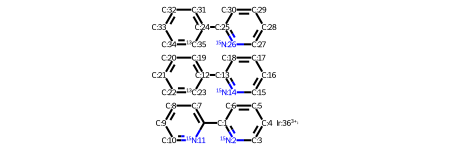

In [17]:
mol_with_atom_index(combo)

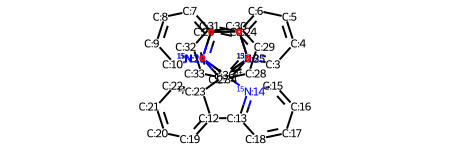

In [18]:
edcombo = Chem.EditableMol(combo)
edcombo.AddBond(2,36,order=Chem.rdchem.BondType.DATIVE)
edcombo.AddBond(11,36,order=Chem.rdchem.BondType.DATIVE)
edcombo.AddBond(14,36,order=Chem.rdchem.BondType.DATIVE)
edcombo.AddBond(23,36,order=Chem.rdchem.BondType.SINGLE)
edcombo.AddBond(26,36,order=Chem.rdchem.BondType.DATIVE)
edcombo.AddBond(35,36,order=Chem.rdchem.BondType.SINGLE)
back = edcombo.GetMol()
back

In [19]:
Ir_smiles = Chem.MolToSmiles(back)
Ir_smiles

'c12[cH:7][cH:8][cH:9][cH:10][15n:11]1->[Ir+3:36]13(<-[15n:2]4[c:1]-2[cH:6][cH:5][cH:4][cH:3]4)(<-[15N:14]2=[C:13]([C:12]4=[CH:19][CH:20]=[CH:21][CH:22]=[13C:23]41)[CH:18]=[CH:17][CH:16]=[CH:15]2)<-[15N:26]1=[C:25]([C:24]2=[CH:31][CH:32]=[CH:33][CH:34]=[13C:35]23)[CH:30]=[CH:29][CH:28]=[CH:27]1'

In [6]:
def remove_isotope(smiles1):
    mol = Chem.MolFromSmiles(smiles1)
    for atom in mol.GetAtoms():
        if atom.GetIsotope():
            atom.SetIsotope(0)
    return mol

In [32]:
def add_bridging_bonds(ligandCN, ligandNN):
    Ir = Chem.MolFromSmiles('[Ir+3]')
    combo1 = Chem.CombineMols(ligandCN, Ir)
    combo2 = Chem.CombineMols(ligandCN, combo1)
    combo = Chem.CombineMols(ligandNN, combo2)
    edcombo = Chem.EditableMol(combo)
    #find all CN atoms to be coordinated
    clist = []
    nlist = []
    for atom in combo.GetAtoms():
        if atom.GetIsotope()>0:
            if atom.GetSymbol()=='C':
                clist.append(atom.GetIdx())
            else:
                nlist.append(atom.GetIdx())
        if atom.GetSymbol()=='Ir':
            Ir_index = atom.GetIdx()
    for cindex in clist:
        edcombo.AddBond(cindex,Ir_index,order=Chem.rdchem.BondType.SINGLE)
    for nindex in nlist:
        edcombo.AddBond(nindex,Ir_index,order=Chem.rdchem.BondType.DATIVE)
    back = edcombo.GetMol()
    #remove isotope
    for atom in back.GetAtoms():
        if atom.GetIsotope():
            atom.SetIsotope(0)
    smiles = Chem.MolToSmiles(back)
    return smiles      

In [41]:
cn = Chem.MolFromSmiles('C1(C2=[15N]C=CC=C2)=CC=CC=[13C]1')
nn = Chem.MolFromSmiles('C1(C2=[15N]C=CC=C2)=CC=CC=[15N]1')

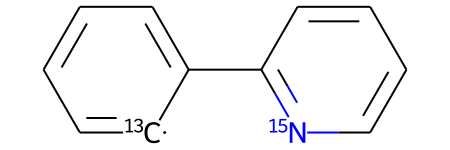

In [42]:
cn

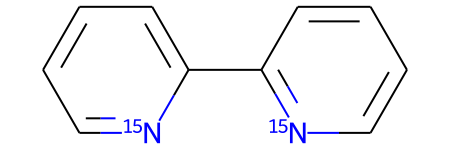

In [43]:
nn

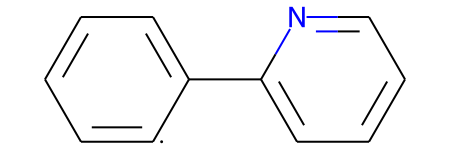

In [19]:
cn_smiles_i = 'C1(C2=[15N]C=CC=C2)=CC=CC=[13C]1'
cn_smiles = remove_isotope(cn_smiles_i)
Chem.MolFromSmiles(cn_smiles)

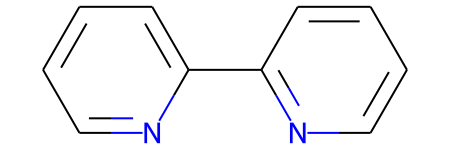

In [50]:
nn_smiles_i = 'C1(C2=[15N]C=CC=C2)=CC=CC=[15N]1'
mol = Chem.MolFromSmiles(nn_smiles_i)
for atom in mol.GetAtoms():
    if atom.GetIsotope():
        atom.SetIsotope(0)
mol

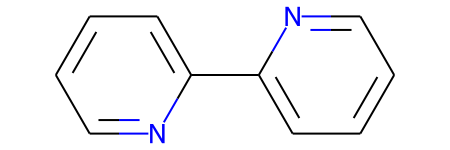

In [51]:
smiles_nn = Chem.MolToSmiles(mol,isomericSmiles=True)
mol2 = Chem.MolFromSmiles(smiles_nn)
mol2

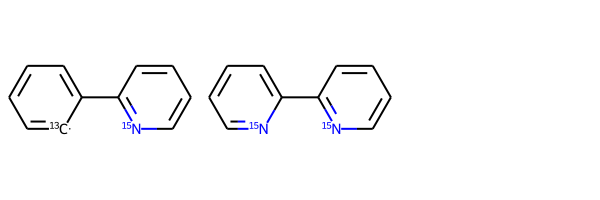

In [6]:
mol_list = [cn,nn]
img_list = Draw.MolsToGridImage(mol_list)
img_list

In [67]:
cluster_smiles = add_bridging_bonds(cn, nn)
cluster_smiles

'c1cc[c]2c(c1)-c1ccccn1[Ir]213([c]2ccccc2-c2ccccn21)n1ccccc1-c1ccccn13'

In [11]:
PandasTools.InstallPandasTools()

In [16]:
smiles = ['c1ccccc1', 'c1ccccc1O', 'c1cc(O)ccc1O']
df = pd.DataFrame({'ID':['Benzene', 'Phenol', 'Hydroquinone'], 'SMILES':smiles})

df['Mol Image'] = [Chem.MolFromSmiles(s) for s in df['SMILES']]

PandasTools.SaveXlsxFromFrame(df, 'test.xlsx', molCol='Mol Image')

## Read Maximum Wavelength from Raw Data

In [2]:
import pandas as pd
import os,sys

In [3]:
cwd = os.getcwd()

In [24]:
df = pd.read_csv(cwd+'/Ir_CNNN_Spectral_Data.csv',skiprows=1)
df.drop('Unnamed: 0', axis=1, inplace=True)
df

,C^N,N^N,400,400.5,401,401.5,402,402.5,403,403.5,...,795,795.5,796,796.5,797,797.5,798,798.5,799,799.5
0,1,1,3.47,4.48,5.34,6.03,6.45,6.61,6.49,6.24,...,10.61,10.24,9.86,9.57,9.48,9.52,9.70,9.90,10.15,10.34
1,2,1,14.01,13.98,13.92,13.81,13.54,13.03,12.31,11.37,...,16.39,14.38,12.28,10.01,7.60,5.06,2.49,0.00,-2.27,-4.54
2,3,1,35.81,33.10,30.16,27.03,23.72,20.14,16.43,12.71,...,21.79,21.34,20.86,20.42,19.87,19.25,18.64,18.15,17.69,17.25
3,4,1,17.57,17.20,16.66,15.94,14.96,13.78,12.35,10.73,...,12.17,12.68,13.04,13.24,13.38,13.56,13.58,13.54,13.46,13.21
4,5,1,35.28,33.43,31.45,29.31,27.11,24.89,22.54,20.12,...,23.76,23.16,22.51,21.79,21.05,20.28,19.58,18.98,18.51,18.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,105,47,23.82,21.40,18.83,16.20,13.61,11.13,8.72,6.31,...,-23.79,-24.24,-24.83,-25.57,-26.54,-27.66,-28.80,-29.92,-31.13,-32.40
1436,106,47,-3.41,-2.21,-1.17,-0.32,0.37,0.92,1.28,1.38,...,-20.02,-19.88,-19.73,-19.56,-19.35,-19.10,-18.95,-18.92,-18.87,-18.70
1437,107,47,8.11,7.37,6.60,5.79,4.90,3.91,2.87,1.83,...,11.32,10.28,9.04,7.58,6.05,4.49,2.92,1.43,0.04,-1.28
1438,108,47,19.35,17.81,16.08,14.34,12.60,10.97,9.39,7.81,...,-9.97,-10.87,-11.81,-12.90,-14.07,-15.45,-16.98,-18.63,-20.13,-21.60


In [25]:
intensity = df.copy()
intensity

,C^N,N^N,400,400.5,401,401.5,402,402.5,403,403.5,...,795,795.5,796,796.5,797,797.5,798,798.5,799,799.5
0,1,1,3.47,4.48,5.34,6.03,6.45,6.61,6.49,6.24,...,10.61,10.24,9.86,9.57,9.48,9.52,9.70,9.90,10.15,10.34
1,2,1,14.01,13.98,13.92,13.81,13.54,13.03,12.31,11.37,...,16.39,14.38,12.28,10.01,7.60,5.06,2.49,0.00,-2.27,-4.54
2,3,1,35.81,33.10,30.16,27.03,23.72,20.14,16.43,12.71,...,21.79,21.34,20.86,20.42,19.87,19.25,18.64,18.15,17.69,17.25
3,4,1,17.57,17.20,16.66,15.94,14.96,13.78,12.35,10.73,...,12.17,12.68,13.04,13.24,13.38,13.56,13.58,13.54,13.46,13.21
4,5,1,35.28,33.43,31.45,29.31,27.11,24.89,22.54,20.12,...,23.76,23.16,22.51,21.79,21.05,20.28,19.58,18.98,18.51,18.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,105,47,23.82,21.40,18.83,16.20,13.61,11.13,8.72,6.31,...,-23.79,-24.24,-24.83,-25.57,-26.54,-27.66,-28.80,-29.92,-31.13,-32.40
1436,106,47,-3.41,-2.21,-1.17,-0.32,0.37,0.92,1.28,1.38,...,-20.02,-19.88,-19.73,-19.56,-19.35,-19.10,-18.95,-18.92,-18.87,-18.70
1437,107,47,8.11,7.37,6.60,5.79,4.90,3.91,2.87,1.83,...,11.32,10.28,9.04,7.58,6.05,4.49,2.92,1.43,0.04,-1.28
1438,108,47,19.35,17.81,16.08,14.34,12.60,10.97,9.39,7.81,...,-9.97,-10.87,-11.81,-12.90,-14.07,-15.45,-16.98,-18.63,-20.13,-21.60


In [26]:
intensity.drop(columns=['C^N','N^N'], axis=1, inplace=True)
intensity

,400,400.5,401,401.5,402,402.5,403,403.5,404,404.5,...,795,795.5,796,796.5,797,797.5,798,798.5,799,799.5
0,3.47,4.48,5.34,6.03,6.45,6.61,6.49,6.24,5.81,5.27,...,10.61,10.24,9.86,9.57,9.48,9.52,9.70,9.90,10.15,10.34
1,14.01,13.98,13.92,13.81,13.54,13.03,12.31,11.37,10.34,9.27,...,16.39,14.38,12.28,10.01,7.60,5.06,2.49,0.00,-2.27,-4.54
2,35.81,33.10,30.16,27.03,23.72,20.14,16.43,12.71,9.10,5.64,...,21.79,21.34,20.86,20.42,19.87,19.25,18.64,18.15,17.69,17.25
3,17.57,17.20,16.66,15.94,14.96,13.78,12.35,10.73,8.93,6.97,...,12.17,12.68,13.04,13.24,13.38,13.56,13.58,13.54,13.46,13.21
4,35.28,33.43,31.45,29.31,27.11,24.89,22.54,20.12,17.70,15.31,...,23.76,23.16,22.51,21.79,21.05,20.28,19.58,18.98,18.51,18.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,23.82,21.40,18.83,16.20,13.61,11.13,8.72,6.31,3.96,1.68,...,-23.79,-24.24,-24.83,-25.57,-26.54,-27.66,-28.80,-29.92,-31.13,-32.40
1436,-3.41,-2.21,-1.17,-0.32,0.37,0.92,1.28,1.38,1.21,0.70,...,-20.02,-19.88,-19.73,-19.56,-19.35,-19.10,-18.95,-18.92,-18.87,-18.70
1437,8.11,7.37,6.60,5.79,4.90,3.91,2.87,1.83,0.97,0.20,...,11.32,10.28,9.04,7.58,6.05,4.49,2.92,1.43,0.04,-1.28
1438,19.35,17.81,16.08,14.34,12.60,10.97,9.39,7.81,6.28,4.75,...,-9.97,-10.87,-11.81,-12.90,-14.07,-15.45,-16.98,-18.63,-20.13,-21.60


In [27]:
df_summary = pd.DataFrame()
df_summary['C^N'] = df['C^N']
df_summary['N^N'] = df['N^N']
df_summary['max_lambda'] = intensity.idxmax(axis="columns")
df_summary

,C^N,N^N,max_lambda
0,1,1,587
1,2,1,593.5
2,3,1,562.5
3,4,1,558.5
4,5,1,559.5
...,...,...,...
1435,105,47,505
1436,106,47,523
1437,107,47,552.5
1438,108,47,562.5


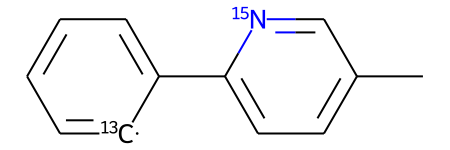

In [71]:
smi = 'CC(C=C1)=C[15N]=C1C2=CC=CC=[13C]2'
mol = Chem.MolFromSmiles(smi)
mol

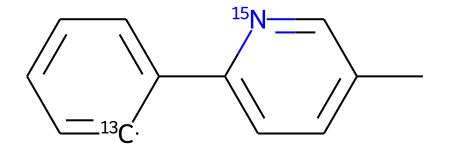

In [72]:
csmi = Chem.CanonSmiles(smi)
cmol = Chem.MolFromSmiles(csmi)
cmol

In [4]:
df_cn = pd.read_csv(cwd+'/CN_smiles.csv')
df_cn

,C^N,CN_smiles
0,1,C1(C2=[15N]C=CC=C2)=CC=CC=[13C]1
1,2,CC(C=C1)=C[15N]=C1C2=CC=CC=[13C]2
2,3,CC(C=C1)=C[15N]=C1C2=CC=C(F)C=[13C]2
3,4,CC(C=C1)=C[15N]=C1C2=CC=C(Cl)C=[13C]2
4,5,CC(C=C1)=C[15N]=C1C2=CC=C(Br)C=[13C]2
5,7,CC(C=C1)=C[15N]=C1C2=CC=C(C#N)C=[13C]2
6,9,CC(C=C1)=C[15N]=C1C2=CC=C(OC)C=[13C]2
7,11,CC(C=C1)=C[15N]=C1C2=C(F)C=C(F)C=[13C]2
8,12,CC(C=C1)=C[15N]=C1C2=C(Cl)C=C(F)C=[13C]2
9,13,CC(C=C1)=C[15N]=C1C2=C(Br)C=C(F)C=[13C]2


In [7]:
df_cn['smiles_cn'] = [Chem.MolToSmiles(remove_isotope(s)) for s in df_cn['CN_smiles']]

In [8]:
df_cn

,C^N,CN_smiles,smiles_cn
0,1,C1(C2=[15N]C=CC=C2)=CC=CC=[13C]1,[c]1ccccc1-c1ccccn1
1,2,CC(C=C1)=C[15N]=C1C2=CC=CC=[13C]2,Cc1ccc(-c2[c]cccc2)nc1
2,3,CC(C=C1)=C[15N]=C1C2=CC=C(F)C=[13C]2,Cc1ccc(-c2[c]cc(F)cc2)nc1
3,4,CC(C=C1)=C[15N]=C1C2=CC=C(Cl)C=[13C]2,Cc1ccc(-c2[c]cc(Cl)cc2)nc1
4,5,CC(C=C1)=C[15N]=C1C2=CC=C(Br)C=[13C]2,Cc1ccc(-c2[c]cc(Br)cc2)nc1
5,7,CC(C=C1)=C[15N]=C1C2=CC=C(C#N)C=[13C]2,Cc1ccc(-c2[c]cc(C#N)cc2)nc1
6,9,CC(C=C1)=C[15N]=C1C2=CC=C(OC)C=[13C]2,COc1c[c]c(-c2ccc(C)cn2)cc1
7,11,CC(C=C1)=C[15N]=C1C2=C(F)C=C(F)C=[13C]2,Cc1ccc(-c2[c]cc(F)cc2F)nc1
8,12,CC(C=C1)=C[15N]=C1C2=C(Cl)C=C(F)C=[13C]2,Cc1ccc(-c2[c]cc(F)cc2Cl)nc1
9,13,CC(C=C1)=C[15N]=C1C2=C(Br)C=C(F)C=[13C]2,Cc1ccc(-c2[c]cc(F)cc2Br)nc1


In [9]:
df_cn.to_csv('CN_smiles_clean.csv')

In [67]:
df_cn['CN_image'] = [remove_isotope(s) for s in df_cn['CN_smiles']]

PandasTools.SaveXlsxFromFrame(df_cn, 'cn_draw_smiles.xlsx', molCol='CN_image')

In [70]:
df_cn['CN_draw'] = [Chem.MolFromSmiles(s) for s in df_cn['CN_smiles']]

PandasTools.SaveXlsxFromFrame(df_cn, 'cn_draw_isotope.xlsx', molCol='CN_draw')

In [11]:
df_nn = pd.read_csv(cwd+'/NN_smiles.csv')

In [12]:
df_nn['smiles_nn'] = [Chem.MolToSmiles(remove_isotope(s)) for s in df_nn['NN_smiles']]
df_nn

,N^N,NN_smiles,smiles_nn
0,1,C1(C2=[15N]C=CC=C2)=CC=CC=[15N]1,c1ccc(-c2ccccn2)nc1
1,2,CC1=CC=[15N]C(C2=[15N]C=CC(C)=C2)=C1,Cc1ccnc(-c2cc(C)ccn2)c1
2,3,CC1=CC=C(C2=[15N]C=C(C)C=C2)[15N]=C1,Cc1ccc(-c2ccc(C)cn2)nc1
3,4,CC1=[15N]C(C2=[15N]C(C)=CC=C2)=CC=C1,Cc1cccc(-c2cccc(C)n2)n1
4,5,C1(C2=[15N]C=CC(C3=CC=CC=C3)=C2)=CC(C4=CC=CC=C...,c1ccc(-c2ccnc(-c3cc(-c4ccccc4)ccn3)c2)cc1
5,6,CC(C)(C)C1=CC=[15N]C(C2=[15N]C=CC(C(C)(C)C)=C2...,CC(C)(C)c1ccnc(-c2cc(C(C)(C)C)ccn2)c1
6,7,FC(C1=CC=C(C2=[15N]C=C(C(F)(F)F)C=C2)[15N]=C1)...,FC(F)(F)c1ccc(-c2ccc(C(F)(F)F)cn2)nc1
7,8,COC1=CC=[15N]C(C2=[15N]C=CC(OC)=C2)=C1,COc1ccnc(-c2cc(OC)ccn2)c1
8,14,O=C1C2=C(C3=[15N]C=CC=C3C1=O)[15N]=CC=C2,O=C1C(=O)c2cccnc2-c2ncccc21
9,16,C1(C2=[15N]C=CC=C2C=C3)=C3C=CC=[15N]1,c1cnc2c(c1)ccc1cccnc12


In [13]:
df_nn.to_csv('NN_smiles_clean.csv')

In [68]:
df_nn['NN_image'] = [remove_isotope(s) for s in df_nn['NN_smiles']]

PandasTools.SaveXlsxFromFrame(df_nn, 'nn_draw_smiles.xlsx', molCol='NN_image')

In [30]:
result1 = pd.merge(df_summary, df_cn, how="left", on="C^N")
result = pd.merge(result1, df_nn, how="left", on="N^N")
result

,C^N,N^N,max_lambda,CN_smiles,NN_smiles
0,1,1,587,C1(C2=[15N]C=CC=C2)=CC=CC=[13C]1,C1(C2=[15N]C=CC=C2)=CC=CC=[15N]1
1,2,1,593.5,CC(C=C1)=C[15N]=C1C2=CC=CC=[13C]2,C1(C2=[15N]C=CC=C2)=CC=CC=[15N]1
2,3,1,562.5,CC(C=C1)=C[15N]=C1C2=CC=C(F)C=[13C]2,C1(C2=[15N]C=CC=C2)=CC=CC=[15N]1
3,4,1,558.5,CC(C=C1)=C[15N]=C1C2=CC=C(Cl)C=[13C]2,C1(C2=[15N]C=CC=C2)=CC=CC=[15N]1
4,5,1,559.5,CC(C=C1)=C[15N]=C1C2=CC=C(Br)C=[13C]2,C1(C2=[15N]C=CC=C2)=CC=CC=[15N]1
...,...,...,...,...,...
1435,105,47,505,CN1N=[15N]C(C2=CC=C(C(F)(F)F)C=[13C]2)=C1,OC(C)(C)C1=CC=C(C2=[15N]C=C(C(O)(C)C)C=C2)[15N...
1436,106,47,523,FC1=CC=C(C2=CN(C)N=[15N]2)[13C]=C1,OC(C)(C)C1=CC=C(C2=[15N]C=C(C(O)(C)C)C=C2)[15N...
1437,107,47,552.5,CN1N=[15N]C(C2=CC=CC=[13C]2)=C1,OC(C)(C)C1=CC=C(C2=[15N]C=C(C(O)(C)C)C=C2)[15N...
1438,108,47,562.5,COC1=CC=C(N2C=CC=[15N]2)[13C]=C1,OC(C)(C)C1=CC=C(C2=[15N]C=C(C(O)(C)C)C=C2)[15N...


In [33]:
smiles_list = []
for i in range(len(result)):
    cn_smiles = result['CN_smiles'][i]
    nn_smiles = result['NN_smiles'][i]
    cn = Chem.MolFromSmiles(cn_smiles)
    nn = Chem.MolFromSmiles(nn_smiles)
    cluster_smiles = add_bridging_bonds(cn, nn)
    smiles_list.append(cluster_smiles)

In [34]:
result['complex_smiles'] = smiles_list
result

,C^N,N^N,max_lambda,CN_smiles,NN_smiles,complex_smiles
0,1,1,587,C1(C2=[15N]C=CC=C2)=CC=CC=[13C]1,C1(C2=[15N]C=CC=C2)=CC=CC=[15N]1,c1cc[c]2c(c1)-c1ccccn1->[Ir+3]213(<-n2ccccc2-c...
1,2,1,593.5,CC(C=C1)=C[15N]=C1C2=CC=CC=[13C]2,C1(C2=[15N]C=CC=C2)=CC=CC=[15N]1,Cc1ccc2n(->[Ir+3]34(<-n5cc(C)ccc5-c5cccc[c]53)...
2,3,1,562.5,CC(C=C1)=C[15N]=C1C2=CC=C(F)C=[13C]2,C1(C2=[15N]C=CC=C2)=CC=CC=[15N]1,Cc1ccc2n(->[Ir+3]34(<-n5cc(C)ccc5-c5ccc(F)c[c]...
3,4,1,558.5,CC(C=C1)=C[15N]=C1C2=CC=C(Cl)C=[13C]2,C1(C2=[15N]C=CC=C2)=CC=CC=[15N]1,Cc1ccc2n(->[Ir+3]34(<-n5cc(C)ccc5-c5ccc(Cl)c[c...
4,5,1,559.5,CC(C=C1)=C[15N]=C1C2=CC=C(Br)C=[13C]2,C1(C2=[15N]C=CC=C2)=CC=CC=[15N]1,Cc1ccc2n(->[Ir+3]34(<-n5cc(C)ccc5-c5ccc(Br)c[c...
...,...,...,...,...,...,...
1435,105,47,505,CN1N=[15N]C(C2=CC=C(C(F)(F)F)C=[13C]2)=C1,OC(C)(C)C1=CC=C(C2=[15N]C=C(C(O)(C)C)C=C2)[15N...,Cn1cc2n(->[Ir+3]34(<-n5cc(C(C)(C)O)ccc5-c5ccc(...
1436,106,47,523,FC1=CC=C(C2=CN(C)N=[15N]2)[13C]=C1,OC(C)(C)C1=CC=C(C2=[15N]C=C(C(O)(C)C)C=C2)[15N...,Cn1cc2n(->[Ir+3]34(<-n5cc(C(C)(C)O)ccc5-c5ccc(...
1437,107,47,552.5,CN1N=[15N]C(C2=CC=CC=[13C]2)=C1,OC(C)(C)C1=CC=C(C2=[15N]C=C(C(O)(C)C)C=C2)[15N...,Cn1cc2n(->[Ir+3]34(<-n5cc(C(C)(C)O)ccc5-c5ccc(...
1438,108,47,562.5,COC1=CC=C(N2C=CC=[15N]2)[13C]=C1,OC(C)(C)C1=CC=C(C2=[15N]C=C(C(O)(C)C)C=C2)[15N...,COc1ccc2[c](c1)[Ir+3]13(<-n4cc(C(C)(C)O)ccc4-c...


In [35]:
df_final = result.copy()
#df_final.drop(columns=['CN_smiles','NN_smiles'],axis=1, inplace=True)
df_final

,C^N,N^N,max_lambda,CN_smiles,NN_smiles,complex_smiles
0,1,1,587,C1(C2=[15N]C=CC=C2)=CC=CC=[13C]1,C1(C2=[15N]C=CC=C2)=CC=CC=[15N]1,c1cc[c]2c(c1)-c1ccccn1->[Ir+3]213(<-n2ccccc2-c...
1,2,1,593.5,CC(C=C1)=C[15N]=C1C2=CC=CC=[13C]2,C1(C2=[15N]C=CC=C2)=CC=CC=[15N]1,Cc1ccc2n(->[Ir+3]34(<-n5cc(C)ccc5-c5cccc[c]53)...
2,3,1,562.5,CC(C=C1)=C[15N]=C1C2=CC=C(F)C=[13C]2,C1(C2=[15N]C=CC=C2)=CC=CC=[15N]1,Cc1ccc2n(->[Ir+3]34(<-n5cc(C)ccc5-c5ccc(F)c[c]...
3,4,1,558.5,CC(C=C1)=C[15N]=C1C2=CC=C(Cl)C=[13C]2,C1(C2=[15N]C=CC=C2)=CC=CC=[15N]1,Cc1ccc2n(->[Ir+3]34(<-n5cc(C)ccc5-c5ccc(Cl)c[c...
4,5,1,559.5,CC(C=C1)=C[15N]=C1C2=CC=C(Br)C=[13C]2,C1(C2=[15N]C=CC=C2)=CC=CC=[15N]1,Cc1ccc2n(->[Ir+3]34(<-n5cc(C)ccc5-c5ccc(Br)c[c...
...,...,...,...,...,...,...
1435,105,47,505,CN1N=[15N]C(C2=CC=C(C(F)(F)F)C=[13C]2)=C1,OC(C)(C)C1=CC=C(C2=[15N]C=C(C(O)(C)C)C=C2)[15N...,Cn1cc2n(->[Ir+3]34(<-n5cc(C(C)(C)O)ccc5-c5ccc(...
1436,106,47,523,FC1=CC=C(C2=CN(C)N=[15N]2)[13C]=C1,OC(C)(C)C1=CC=C(C2=[15N]C=C(C(O)(C)C)C=C2)[15N...,Cn1cc2n(->[Ir+3]34(<-n5cc(C(C)(C)O)ccc5-c5ccc(...
1437,107,47,552.5,CN1N=[15N]C(C2=CC=CC=[13C]2)=C1,OC(C)(C)C1=CC=C(C2=[15N]C=C(C(O)(C)C)C=C2)[15N...,Cn1cc2n(->[Ir+3]34(<-n5cc(C(C)(C)O)ccc5-c5ccc(...
1438,108,47,562.5,COC1=CC=C(N2C=CC=[15N]2)[13C]=C1,OC(C)(C)C1=CC=C(C2=[15N]C=C(C(O)(C)C)C=C2)[15N...,COc1ccc2[c](c1)[Ir+3]13(<-n4cc(C(C)(C)O)ccc4-c...


In [63]:
df_final['CN_image'] = [remove_isotope(s) for s in df_final['CN_smiles']]
df_final['NN_image'] = [remove_isotope(s) for s in df_final['NN_smiles']]

PandasTools.SaveXlsxFromFrame(df_final, 'cn_image.xlsx', molCol='CN_image')

In [66]:
df_final['NN_image'] = [remove_isotope(s) for s in df_final['NN_smiles']]

PandasTools.SaveXlsxFromFrame(df_final, 'nn_image.xlsx', molCol='NN_image')

In [37]:
df_final.to_csv('IrCNNN_smiles_dative.csv')

In [36]:
complex_smiles_1 = df_final['complex_smiles'][1]
complex_smiles_1


'Cc1ccc2n(->[Ir+3]34(<-n5cc(C)ccc5-c5cccc[c]53)(<-n3ccccc3-c3ccccn->43)[c]3ccccc3-2)c1'

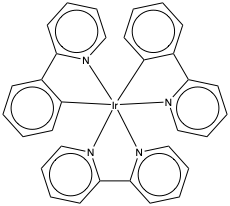